In [14]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from pickle import load
import re
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import wandb
from loguru import logger
from train_config import CFG
import warnings
from tfswin import SwinTransformerTiny224, preprocess_input
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

CFG = CFG()

In [32]:
try:  # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # detect GPUs
    strategy = tf.distribute.get_strategy()  # default strategy that works on CPU and single GPU

REPLICAS = strategy.num_replicas_in_sync
print("Number of Accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttribute

In [33]:
# Model
IMAGE_SIZE = CFG.IMAGE_SIZE

BATCH_SIZE =  REPLICAS * CFG.BASE_BATCH_SIZE

class_dict = load(open("class_dict.pkl", "rb"))

AUTO = tf.data.AUTOTUNE

In [34]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

def decode_image(image_data, CFG):
    image = tf.image.decode_jpeg(image_data, channels=3)  # image format uint8 [0,255]
    image = tf.cast(image, tf.float32) # / 255.0
    image = tf.image.resize(image, size=CFG.IMAGE_SIZE, method="lanczos5")
    # image = (image - MEAN) / STD
    # image = tf.clip_by_value(image, 0, 255)
    # image = tf.cast(image, tf.float32)
    
    return image

def read_labeled_tfrecord(example, CFG):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "dataset": tf.io.FixedLenFeature([], tf.int64),
        "longitude": tf.io.FixedLenFeature([], tf.float32),
        "latitude": tf.io.FixedLenFeature([], tf.float32),
        "norm_date": tf.io.FixedLenFeature([], tf.float32),
        "class_priors": tf.io.FixedLenFeature([], tf.float32),
        "class_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example["image"], CFG)
    label = tf.cast(example["class_id"], tf.int32)
    return image, label

def load_dataset(filenames, CFG):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(lambda x: read_labeled_tfrecord(x, CFG), num_parallel_calls=AUTO)
  return dataset

def get_model(model_url: str, res: int = 224, num_classes: int = 467) -> tf.keras.Model:
    inputs = layers.Input(shape=(res, res, 3), dtype='uint8')
    outputs = layers.Lambda(preprocess_input)(inputs)
    outputs = SwinTransformerTiny224(include_top=False)(outputs)
    outputs = layers.Dense(num_classes, activation='softmax')(outputs)

    return models.Model(inputs, outputs)

def get_batched_dataset(filenames, CFG, train=False):
  dataset = load_dataset(filenames, CFG)
  # dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
    dataset = dataset.shuffle(BATCH_SIZE * 10)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  # In eager mode, iterate in the Datset directly.
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break

  return numpy_images, numpy_labels

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = class_dict[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [35]:
GCS_PATH_SELECT = {
    192: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-192x192",
    224: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-224x224v2",
    256: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-256x256",
    384: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-384x384",
    512: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-512x512",
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

training_filenames = tf.io.gfile.glob(f"{GCS_PATH}/train*.tfrec")
validation_filenames = tf.io.gfile.glob(f"{GCS_PATH}/val*.tfrec")

num_train = count_data_items(training_filenames)
num_val = count_data_items(validation_filenames)

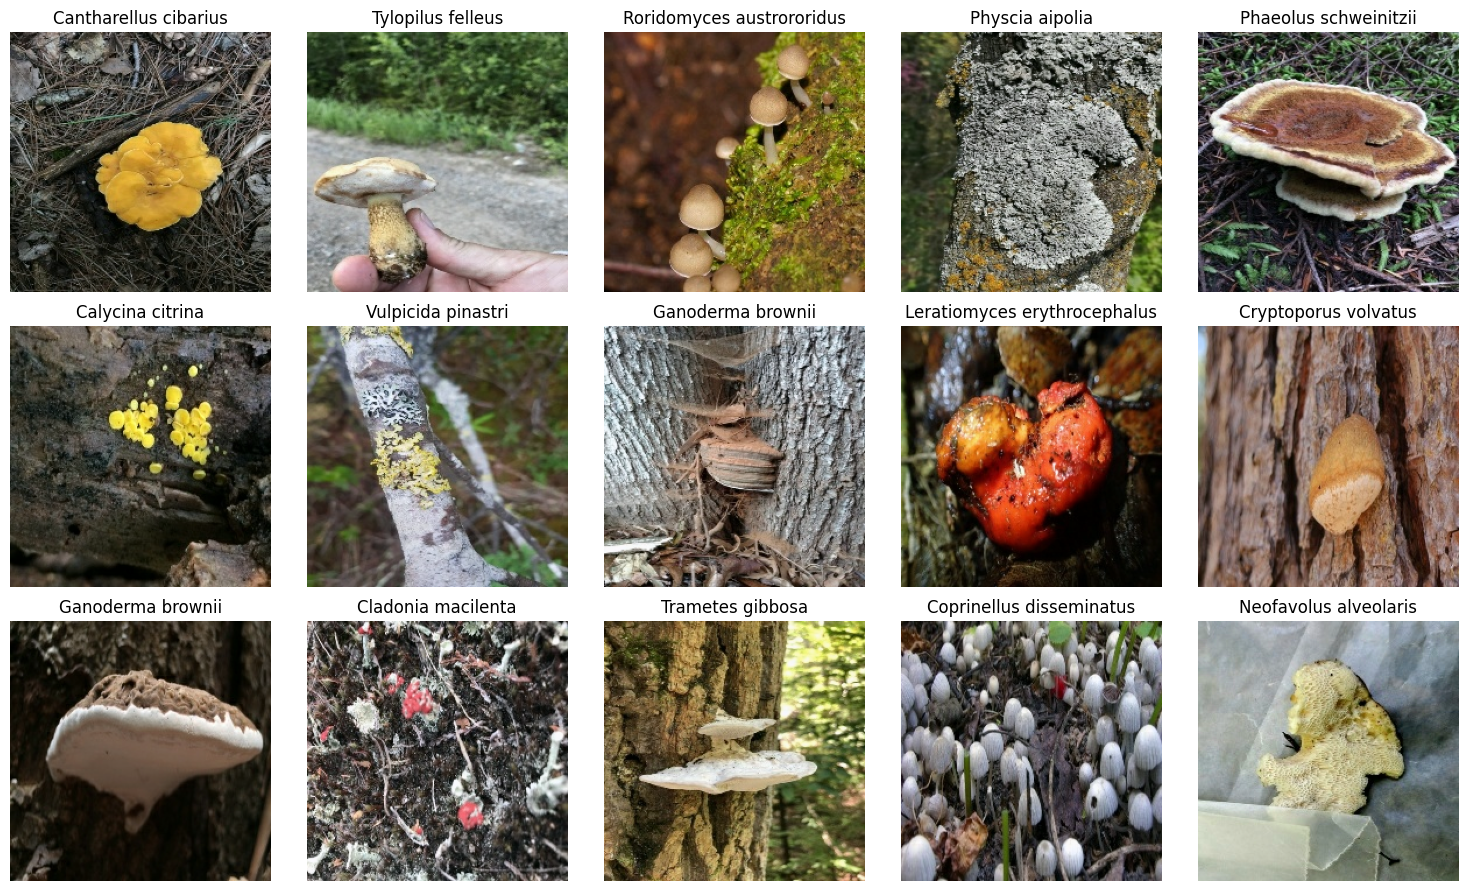

In [28]:
sample_images, sample_labels = next(iter(get_batched_dataset(training_filenames, CFG, train=True)))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n] * STD + MEAN).numpy()
    image = image[:, :, ::-1]
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(class_dict[sample_labels.numpy()[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [36]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [37]:
EPOCHS = CFG.EPOCHS
WARMUP_STEPS = 10
INIT_LR = 0.03
WARMUP_LR = 0.006

TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)
validation_steps = num_val // BATCH_SIZE
steps_per_epoch = num_train // BATCH_SIZE

scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WARMUP_LR,
    warmup_steps=WARMUP_STEPS,
)

In [39]:
optimizer = keras.optimizers.AdamW(scheduled_lrs)
loss = keras.losses.SparseCategoricalCrossentropy()

In [40]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)
    model = get_model('url', num_classes=len(class_dict))
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

2023-11-13 10:42:24.994550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 10:42:25.044957: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-13 10:42:25.162332: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:42:25.162416: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


177485300/177485300 [==============================] - 1s 0us/step


In [12]:
CFG.WARMUP_STEPS, CFG.INIT_LR, CFG.WARMUP_LR, CFG.TOTAL_STEPS, CFG.BATCH_SIZE = WARMUP_STEPS, INIT_LR, WARMUP_LR, TOTAL_STEPS, BATCH_SIZE
config=wandb.helper.parse_config(
    CFG, include=('ALPHA', 'AUGMENT', 'BATCH_SIZE', 'EPOCHS', 'ES_PATIENCE', 'FOLDS', 'IMAGE_SIZE', 'LR_START', 'MODEL_SIZE', 'SEED', 'TTA', 'WARMUP_LR', 'WARMUP_STEPS', 'TOTAL_STEPS', 'INIT_LR')
)
wandb.init(
    project="Mushroom-Classifier",
    tags=['swin_large_224_new', 'SGD', 'CosineWarmup-self', str(CFG.IMAGE_SIZE[0])],
    config=config,
    dir="../",
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: g-broughton. Use `wandb login --relogin` to force relogin


In [13]:
CFG.CKPT_DIR.mkdir(parents=True, exist_ok=True)
callbacks = [
    wandb.keras.WandbMetricsLogger(log_freq="epoch"),
    wandb.keras.WandbModelCheckpoint(
        str(CFG.CKPT_DIR),  # .h5 for weights, dir for whole model
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        # options=options,
        initial_value_threshold=0.8,
    ),    
]

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [41]:
tr_ds = get_batched_dataset(training_filenames, CFG, train=True)
val_ds = get_batched_dataset(validation_filenames, CFG)

history = model.fit(
    tr_ds, 
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    epochs=EPOCHS, 
    # callbacks=callbacks
    )

2023-11-13 10:43:11.371722: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:43:11.400986: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:43:11.430123: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:43:11.460004: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:43:11.489352: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:43:11.518433: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:43:11.547197: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/30


2023-11-13 10:44:01.436523: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:241] Subgraph fingerprint:17964823540685192086
2023-11-13 10:44:06.086842: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-11-13 10:44:13.028286: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:44:13.028411: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:44:13.028516: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:44:13.029155: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 10:44:13.029380: E ./tensorflow/compiler/xla/stream_executor/

: 